# Diffusion of Mg and Sr in plagioclase: A Finite Difference Method Approach
*Jordan Lubbers* <br>
*Alaska Volcano Observatory U.S. Geological Survey* <br>

Utilizes the forward difference scheme to the finite difference method for Fick's $2^{nd}$ Law

Both the diffusion (e.g., Costa et al., 2003; Van Orman et al., 2014; Druitt et al., 2012) and partition (e.g., Bindeman et al., 1998; Nielsen et al., 2017; Dohmen and Blundy 2014) coefficients of Sr and Mg in plagioclase are compositionally dependent (i.e. the rate at which these processes occur increase with decreasing An content). Costa and others (2003; Eq. 7) derive a solution to the diffusion equation that incorporates this:
\begin{equation}\label{costa_eq}
\frac{\delta C}{\delta t} = \left(\frac{\delta D}{\delta x}\frac{\delta C}{\delta x}+D\frac{\delta^2C}{\delta x^2}\right) - \frac{A}{RT}\left(D\frac{\delta C}{\delta x}\frac{\delta X_{An}}{\delta x}+C\frac{\delta D}{\delta x}\frac{\delta X_{An}}{\delta x}+DC\frac{\delta^2X_{An}}{\delta x^2} \right) 
\end{equation}
\
We can see here that the first part of the equation deals with the diffusion of matter, and the second part of the equation pertains to the Arrhenius partitioning relationship. Discretizing this equation we get the following:
\begin{equation}\label{plag_FD}
C_{i,j+1} = C_{i,j} + \Delta t\Bigg\{\left[\left(\frac{D_{i+1,j}-D_{i,j}}{\Delta x}\right)\left(\frac{C_{i+1,j}-C_{i,j}}{\Delta x}\right)+D_{i,j}\left(\frac{C_{i+1,j}-2C_{i,j}+C_{i-1,j}}{\Delta x^2}\right)\right] - \frac{A}{RT}\left[ D_{i,j}\left(\frac{C_{i+1,j}-C_{i,j}}{\Delta x}\cdot\frac{An_{i+1,j}-An_{i,j}}{\Delta x}\right)+C_{i,j}\left(\frac{D_{i+1,j}-D_{i,j}}{\Delta x}\cdot\frac{An_{i+1,j}-An_{i,j}}{\Delta x}\right)+D_{i,j}C_{i,j}\left(\frac{An_{i+1,j}-2An_{i,j}+An_{i-1,j}}{\Delta x^2}\right)\right]\Bigg\}
\end{equation}

- $C_{i,j+1}$ is the concentration of a trace element at a point in space $i$ and time $j$
- $D_{i,j+1}$ is the diffusion coefficient of a trace element at a point in space $i$ and time $j$
- $An_{i,j}$ is the anorthite of the plag a point in space $i$ and time $j$
- $\Delta t$ is the time spacing between $j$ steps
- $\Delta x$ is the distance spacing between $i$ steps.
- $A$ is the constant from Nielsen et al., (2017) for $Mg$ partitioning in plagioclase
- $R$ and $T$ are the universal gas constant $8.314 \frac{J}{mol\cdot K}$ and temperature in Kelvin, respectively

Below we outline a forward model to quantify the degree of either Sr or Mg diffusive equilibration that has transpired in plagioclase across a given chemical potential

## Import dependencies
These are the packages we'll be utilizing:


In [1]:
# core packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import sys

# path to plag_diff.py
# functions specific for forward modeling
# of diffusion in plagioclase
sys.path.append(
    r"C:\Users\jlubbers\OneDrive - DOI\Research\Coding\Python_scripts\Diffusion"
)
import plag_diff as plag


# path to default plotting preferences script
sys.path.append(r"C:\Users\jlubbers\OneDrive - DOI\Research\Coding\Python_scripts")
import mpl_defaults

# export all figures here
export_path = (
    r"C:\Users\jlubbers\OneDrive - DOI\Desktop\test_figures"
)

## Import data
Here we bring in our data. It should be in [wide](https://www.statology.org/long-vs-wide-data/) format (e.g., columns denote different analytes and rows are individual observations) with a column that denotes which transect each observation belongs to. We set this as the index for the dataframe such that it can be used to easily index all the data for an individual transect.

In [2]:
# import data
data = pd.read_excel(
    r"C:\Users\jlubbers\OneDrive - DOI\Research\Phd_research\Writing\Galan_manuscript\CGI_supplementary_all.xlsx",
    sheet_name="laser feldspar",
)
data = data.set_index("mineral").loc["plag", :].reset_index().set_index("grain")

print(data.index.unique().tolist())

['1_5', '1_6', '1_7-1', '1_7-2', '5_3', '5_4', '5_5', '5_6', '5_7-1', '5_7-2', '5_8', '5_8-2', '5_8-3', '5_10', '8_4', '8_6', 'ns1_1', 'ns1_3', 'ns1_4', 'ns1_5', 'ns1_6', 'ns2_1', 'ns2_2', 'ns8_1-1', 'ns8_1-2', 'ns8_2-1', 'ns8_2-2', 'ns8_2-3', 'ns14_1', 'ns14_2-1', 'ns14_2-2', 'ns14_3', 'ns15_1-1', 'ns15_1-2', 'ns15_2', 'ns18_1-1', 'ns18_1-2', '8_9', '8_10', '8_11', '9_3_1', '9_3_2', '9_7', '9_8', '9_10_1', '9_10_2', '9_12', '11_1', '11_8_1', '11_8_2', '11_8_3', '11_8_4', '11_9', '14_2', '14_4', '14_6', '14_7', '14_8_1', '14_8_2', '14_8_3', '14_10', '15_1_1', '15_1_2', '15_4', '15_5_1', '15_5_2', '15_6', '15_8', '15_12', '18_2', '18_3_1', '18_3_2', '18_4_1', '18_4_2', '18_4_3', '18_5_1', '18_5_2', '18_6', '18_10', '18_11_1', '18_11_2']


Text(0.5, 0, 'Distance ($\\mu$m)')

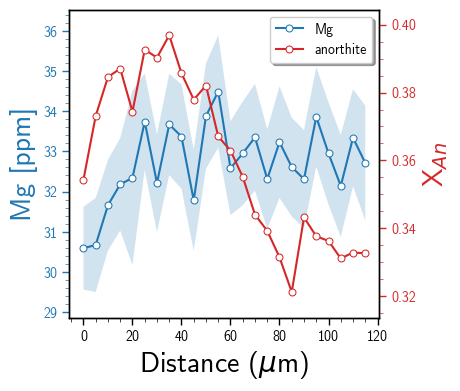

In [3]:
# specify which grain to use
grain = "11_8_3"

# specify which element to model
# Sr or Mg
element = "Mg"

resolution = 5.0  # um

# for consistent colors throughout
obs_color = "C0"  # observed data
eq_color = "C1"  # equilibrium data
an_color = "C3"
init_color = "k"  # initial profile related data
bf_color = "C2"


# the domain you wish to model diffusion over
# try to keep this untouched but if there are
# erroneous ends on your data this will clip them
start = 0
stop = 0


# unclipped data for a grain
# distance
dist_all = np.arange(0, data.loc[grain, :].shape[0]) * resolution
# measured trace element information
te_all = data.loc[grain, element].to_numpy()
te_unc_all = data.loc[grain, "{}_se".format(element)].to_numpy()
# anorthite
an_all = data.loc[grain, "An"].to_numpy()
if np.unique(an_all > 1)[0] == True:
    an_all = an_all / 100
# clipped data. If above start and stop are 0 they
# will be the same as the unclipped data. This is fine.
te = te_all[start : len(te_all) - stop]
te_unc = te_unc_all[start : len(te_all) - stop]
dist = dist_all[start : len(te_all) - stop]
an = an_all[start : len(te_all) - stop]


# plot observed data
fig, ax = plt.subplots(figsize=(4, 4))
# observed profile and subset
(l1,) = ax.plot(
    dist,
    te,
    c=obs_color,
    marker="o",
    mfc="w",
    mec=obs_color,
    ms=5,
    mew=0.75,
    label=element,
)
ax.fill_between(dist, te + te_unc, te - te_unc, alpha=0.2)

ax2 = ax.twinx()
(l2,) = ax2.plot(
    dist,
    an,
    c=an_color,
    marker="o",
    mfc="w",
    mec=an_color,
    ms=5,
    mew=0.75,
    label="anorthite",
)
ax2.tick_params(axis="y", which="both", colors=an_color)
ax2.set_ylabel("X$_{An}$", c=an_color)

ax.legend(handles=[l1, l2], fancybox=True, shadow=True)
# fig.legend(loc="best")

ax.set_ylabel("{} [ppm]".format(element), c=obs_color)
ax.tick_params(axis="y", which="both", colors=obs_color)
ax.set_xlabel("Distance ($\mu$m)")

## Equilibrium profiles

The equilibrium profile can be thought of as the "final" position at which diffusion progresses for a given An composition. Because NaSi - CaAl interdiffusion in plagiocalse is extremely slow we treat the An profile as fixed, which ultimately means that the equilibrium profile is also fixed for a given transect. We calculate this using standard partition coefficient relationships:

$$\large{C_s = C_lK_d} $$

Which, when we substitue in the Arrhenius partitioning relationship for trace elements for plagioclase, yields:

$$\large{{Mg_{eq}}^{sol} = C_l\exp{\left({\frac{AX_{An}+B}{RT}}\right)}}$$

In this case, $C_l$ is also calculated using the composition of the plagioclase rim and the partition coefficient at that point:

$$\large{C_l = \frac{Mg^{rim}}{{K_d}^{rim}}} $$

Similarly, we calculate the liquid composition from which a given plagioclase composition formed as follows:

$$\large{{Mg_{eq}}^{liq} = \frac{Mg_i}{{K_d}_i}}$$

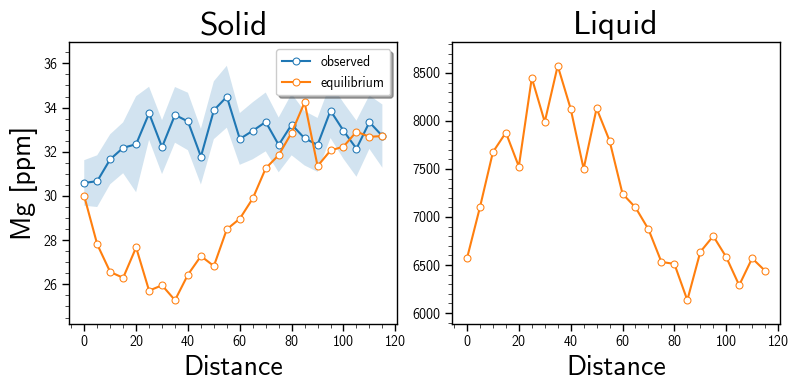

In [4]:
# Thermodynamic parameters
T_K = 1023.15  # K
R = 8.314

# plagioclase partitioning information
# partition coefficient, uncertainty, A, B params
# options are "Bindeman", "Nielsen", "Tepley"
method = "Bindeman"
kd, rtlnk, A, B = plag.plag_kd_calc(element, an, T_K - 273.15, method=method)


# concentration of the 'rim-most' equilibrium liquid
cl_rim = te[-1] / kd[-1]


# equilibrium profile based on established equilibrium liquid concentration
# at the rim
eq_prof = cl_rim * kd


# Assumed equilibrium liquid based on partition coefficients
# and the observed concentration at each spot
equilibrium_liquid = te / kd

# range of anorthite compositions to calculate equilibrium curves
An_partition = np.linspace(0, 1, te.shape[0])


# plotting things up
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(
    dist,
    te,
    label="observed",
    c=obs_color,
    marker="o",
    mfc="w",
    mec=obs_color,
    ms=5,
    mew=0.75,
)
ax[0].fill_between(dist, te + te_unc, te - te_unc, alpha=0.2)
ax[0].plot(
    dist,
    eq_prof,
    label="equilibrium",
    c=eq_color,
    marker="o",
    mfc="w",
    mec=eq_color,
    ms=5,
    mew=0.75,
)
# ax[0].fill_between(dist,eq_prof + eq_prof_unc, eq_prof - eq_prof_unc,alpha = .2)
ax[0].legend(fancybox=True, shadow=True)
ax[0].set_ylabel("{} [ppm]".format(element))
ax[0].set_xlabel("Distance")
ax[0].set_title("Solid", fontsize=24)

ax[1].plot(
    dist,
    equilibrium_liquid,
    c=eq_color,
    marker="o",
    mfc="w",
    mec=eq_color,
    ms=5,
    mew=0.75,
)
ax[1].set_xlabel("Distance")
ax[1].set_title("Liquid", fontsize=24)

fig.tight_layout()

## Model Initial condition

Arguably one of the most important decisions in any diffusion model is the choice of the "initial profile" (i.e., the point from which diffusion began). To calculate this, we take the equilibrium liquid profile from which the plagioclase should've formed (right figure above) and simplify it by turning it into a series of either two or three unique compositions. In doing this, we assume much of the noise in the calculated liquid profile is either analytical or related to diffusion in the crystal. Generally, a good approach here is to keep it simple and only create "steps" for large excursions in the profile. Once this simplified profile is created we can back calculate a profile that should resemble what existed in the crystal prior to diffusion taking place. 

Here we also calculate the numerical stability of our model, which is defined as:

$$\large{r = \frac{D\Delta t}{\Delta x^2}}$$

This value must be below 0.5 for the model to be considered numerically stable. If for some reason you find yourself doing diffusion modeling in 2D or 3D, this value halves for every dimension added (e.g., 0.25 and 0.125 for 2D and 3D respectively)

The lowest possible timescale resolvable is a function of the diffusion coefficient and analytical resolution (Bradshaw and Kent, 2017). This value is shown in the left figure below. While a model may produce a timescale lower than this value, it technically is too fast to be accurately resolvable and should be reported as such.

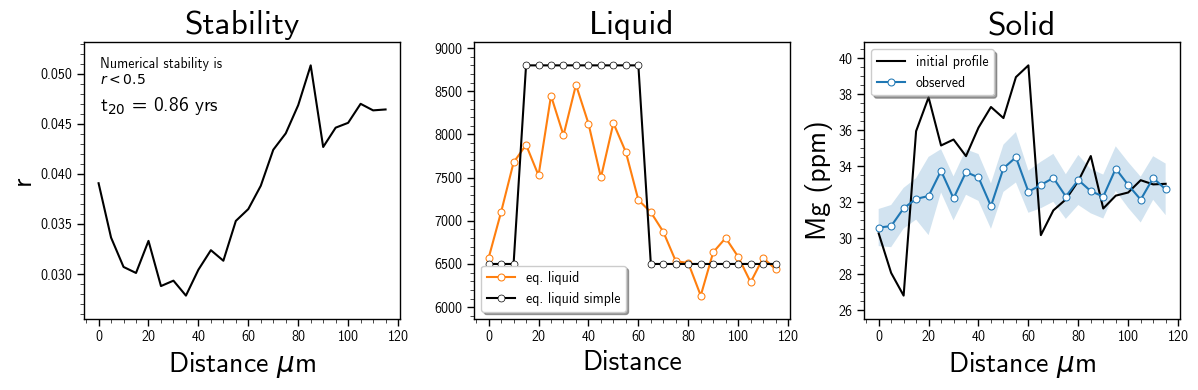

In [5]:
# x spacing
dx = dist[1] - dist[0]

# instantiate container that will be
# simple liquid profile
simple_liquid = np.zeros(dist.shape[0])

# ------------------------------------------------------
# initial condition as a step function
# these numbers are the actual distance in microns
# we convert them to their index in the array later
stepstart = 15 - np.min(dist)
stepstop = 65 - np.min(dist)

# boundary conditions in ppm for left, middle, and right
step_left = 6500
step_middle = 8800
step_right = 6500

step_begin = stepstart
step_begin_idx = int(step_begin / dx)
step_stop = stepstop
step_stop_idx = int(step_stop / dx)

# first step function
simple_liquid[:step_begin_idx] = step_left
simple_liquid[step_begin_idx:step_stop_idx] = step_middle
simple_liquid[step_stop_idx:] = step_right
# #------------------------------------------------------
# # second step function
# stepstart2 = 15 - np.min(dist)
# stepstop2 = 65 - np.min(dist)

# # # boundary conditions in ppm for left, middle, and right
# step_left2 = step_right
# step_middle2 = 1800
# step_right2 = 4000

# step_begin2= stepstart2
# step_begin_idx2= int(step_begin2 / dx)
# step_stop2 = stepstop2
# step_stop_idx2 = int(step_stop2/ dx)

# simple_liquid[step_stop_idx:step_begin_idx2] = step_right
# simple_liquid[step_begin_idx2:step_stop_idx2] = step_middle2
# simple_liquid[step_stop_idx2:] = step_right2
# # # #-------------------------------------------------------
# # third step function
# stepstart3 = 310 - np.min(dist)
# stepstop3= 400 - np.min(dist)

# step_left3 = step_right2
# step_middle3 = 10000
# step_right3 = 160

# step_begin3 = stepstart3
# step_begin_idx3 = int(step_begin3 / dx)
# step_stop3= stepstop3
# step_stop_idx3 = int(step_stop3 / dx)

# # first step function
# simple_liquid[step_stop_idx2:step_begin_idx3] = step_right2
# simple_liquid[step_begin_idx3:step_stop_idx3] = step_middle3
# simple_liquid[step_stop_idx3:] = step_right3
# #--------------------------------------------------------

# create the initial profile based on the simple
# liquid profile using partition coefficients
initial_profile = kd * simple_liquid.copy()


# since our Di is in um^2/s we need to factor that into our time grid
# by spacing out the points accordingly.
# 10,000 years iterating by tenths of year
iterations = int(10 * 1e4)
timestep = "tenths"

# creating a time grid that is spaced by years
t = plag.get_tgrid(iterations, timestep)

# simple moving average to smooth out the An profile slightly
# Very "spiky" An signals have the potential to create
# errors in the diffusion curve that propagate out of
# control.
an_smooth = np.convolve(an, np.ones(3), "valid") / 3
an_smooth = np.insert(an_smooth, 0, an[0])
an_smooth = np.append(an_smooth, an[-1])


# Van Orman et al 2013 diffusion coefficient
# diffusivity in (um^2/s)
D = plag.plag_diffusivity(element, an, T_K, method="van orman")

# numerical stability value
r = (D * (t[1] - t[0])) / dx ** 2


fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].set_title("Stability", fontsize=24)
ax[0].plot(dist, r, init_color)
ax[0].set_ylabel("r", fontsize=20)
ax[0].set_xlabel("Distance $\mu$m", fontsize=20)
t20 = (0.24 * (((dist[1] - dist[0]) * 1e-6) ** 2) / (D / 1e12)) / (
    60 * 60 * 24 * 365.25
)

ax[0].text(0.05, 0.85, "Numerical stability is\n$r<0.5$", transform=ax[0].transAxes)
ax[0].text(
    0.05,
    0.75,
    "t$_{{20}}$ = {} yrs".format(np.round(t20.max(), 2)),
    transform=ax[0].transAxes,
    fontsize=14,
)


ax[1].plot(
    dist,
    equilibrium_liquid,
    c=eq_color,
    marker="o",
    mfc="w",
    mec=eq_color,
    ms=5,
    mew=0.75,
    label="eq. liquid",
)
ax[1].plot(
    dist,
    simple_liquid,
    c="k",
    marker="o",
    mfc="w",
    mec="k",
    ms=5,
    label="eq. liquid simple",
)
ax[1].set_xlabel("Distance")
ax[1].set_title("Liquid", fontsize=24)

ax[1].legend(loc="best", shadow=True, fancybox=True)


ax[2].set_title("Solid", fontsize=24)
ax[2].plot(dist, initial_profile, init_color, label="initial profile")
ax[2].plot(
    dist,
    te,
    label="observed",
    c=obs_color,
    marker="o",
    mfc="w",
    mec="C0",
    ms=5,
    mew=0.75,
)
ax[2].fill_between(dist, te + te_unc, te - te_unc, alpha=0.2)
ax[2].set_ylabel("{} (ppm)".format(element), fontsize=20)
ax[2].set_xlabel("Distance $\mu$m", fontsize=20)
ax[2].legend(loc="upper left", shadow=True, fancybox=True)


fig.tight_layout()

##### The Diffusion Equation

Here is where we apply the discretized diffusion equation listed above to our initial profile. To make this easier to implement we have created a function that takes the following arguments: 
- ```initial_profile```: the initial profile for your model. This was defined above
- ```boundary```. How to treat the most "rimward" boundary of the model. There are three options in this regargd:
    1. ```infinite observed```: a fixed reservoir assumption where the most rimward point is fixed at the value that is determined by the most rimward analysis
    2. ```infinite model```: similar to ```infinite observed```, however the value is fixed at the most rimward initial profile value
    3. ```open```: this does not fix the most rimward analysis and lets it diffuse like the rest of the points. This may be useful if you have a transect that is not necessarily at the rim of the grain
    
The function will create a 2D array of values where each row pertains to a diffusion curve for a given timestep. We calculate the fit of a given point in a curve as follows:

$$\large{\chi^2 = \frac{[Mg_{obs} - Mg_{model}]^2}{Mg_{obs}}}$$

We then sum these values for an entire timestep curve. The timestep that has the lowest overall misfit is the best model fit. 


To see more on how to optimize performance of the diffusion equation, see this [walkthrough](https://drive.google.com/file/d/1Tig0Ex6ZiVMGUX5Xusm2lfVL8LBtROBb/view?usp=sharing). 

In [6]:
# run the forward diffusion model
curves = plag.diffuse_forward(
    initial_profile, te, t, D, an_smooth, A*1000, dist, T_K, boundary="infinite observed"
)

# find the best fit iteration
bf_time, chi2 = plag.fit_model(te, curves)

100%|██████████| 100001/100001 [00:02<00:00, 34274.64timestep/s]


## Visualize our results

Below we visualize our model results. The figure layout is as follows:
- upper left: observed data, equilibrium profile, model best fit curve
- upper right: misfit for each timestep of the model
- lower left: observed data and anorthite profile
- lower right: trace element vs An as well as the equilibrium range as defined by Bindeman et al., 1998 partitioning model. 



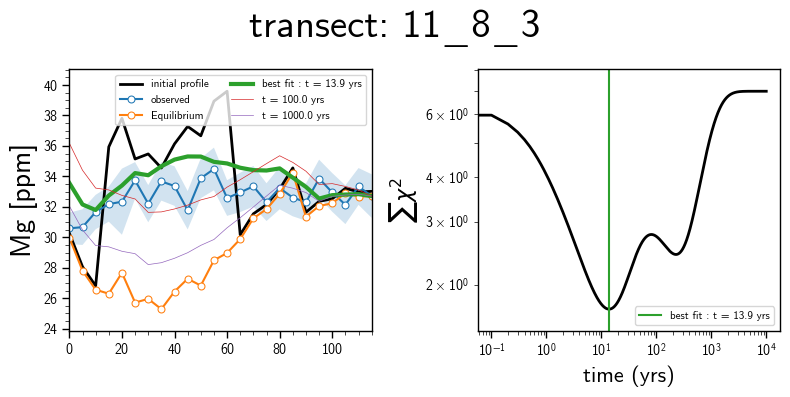

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4),)
makeyears = 10
ms = 5
ax[0].plot(dist, initial_profile, "k-", lw=2, label="initial profile")
ax[0].plot(
    dist, te, label="observed", c="C0", marker="o", mfc="w", mec="C0", mew=0.75, ms=ms
)
ax[0].fill_between(dist, te + te_unc, te - te_unc, alpha=0.2)
ax[0].plot(
    dist,
    eq_prof,
    c="C1",
    marker="o",
    mfc="w",
    mec="C1",
    mew=0.75,
    label="Equilibrium",
    ms=ms,
)  # boundary conditions
ax[0].plot(
    dist,
    curves[bf_time],
    "-",
    c=bf_color,
    mec="k",
    lw=3,
    label="best fit : t = {} yrs".format(np.round(bf_time / makeyears, 2)),
)

# #comparison curves. Omit this if you don't want them
compare = [makeyears * 100, makeyears * 1000]
compare_colors = ["C3", "C4"]
for i in range(0, len(compare)):
    ax[0].plot(
        dist,
        curves[compare[i]],
        label="t = {} yrs".format(compare[i] / makeyears),
        lw=0.5,
        color=compare_colors[i],
    )

ax[0].legend(loc="best", prop={"size": 8}, ncol=2)
ax[0].set_ylabel("{} [ppm]".format(element), fontsize=20)
ax[0].set_xlim(left=np.min(dist), right=np.max(dist))


# chi-squared plot
# convert to days
tdays = t / (t[1] - t[0])
ax[1].plot(
    tdays / makeyears, chi2, "-k", lw=2,
)
# vertical line at best fit value
ax[1].axvline(
    bf_time / makeyears,
    color=bf_color,
    label="best fit : t = {} yrs".format(np.round(bf_time / makeyears, 2)),
)
ax[1].set_xlabel("time (yrs)", fontsize=16)
ax[1].set_ylabel("$\sum{\chi^2} $", fontsize=16)
ax[1].set_xscale("log")
ax[1].legend(loc="best", prop={"size": 8})
ax[1].set_yscale("log")
fig.suptitle("transect: {}".format(grain), fontsize=28)

fig.tight_layout()

## Uncertainties

Uncertainties for a given diffusion model are evaluated using a Monte Carlo approach where 1000 random profiles are generated for each modeled profile. Random profiles are generated based on the analytical uncertainty at each analyzed point (i.e., for each point in the profile a normally distributed random number was generated based on the observed mean analysis value and its 1 sigma uncertainty). Best fit diffusion times were then fit to each random profile in the Monte Carlo simulation keeping the initial boundary conditions and temperature fixed. As we are quantifying a duration above a certain temperature,  and not a measured temperature with an uncertainty, we keep this temperature fixed as well. If a temperature is calculated, however, this may also be randomly generated based on a mean and standard deviation just like the trace element data. Overall uncertainties for a given diffusion model were calculated by taking the mean and standard deviation for the Monte Carlo simulation. 

In [8]:
# set the limit to search for best time in each model
# to number of timesteps  in model above
limit = iterations
# number of models to run in Monte Carlo
n = 1000
# run the Monte Carlo
best_fits = plag.Monte_Carlo_FD(
    initial_profile,
    te,
    te_unc,
    t,
    D,
    an_smooth,
    A*1000,
    dist,
    T_K,
    n,
    limit,
    boundary="infinite observed",
    local_minima=False,
)

100%|██████████| 1000/1000 [00:05<00:00, 186.26it/s]


## Model Summary plot

### A
Here we have the observed data that is being modeled. This includes both the trace element being modeled and the anorthite profiles.

### B
In this panel we have the equilibrium liquid profile representing an effective melt profile that the plagioclase should've formed from neglecting diffusion and the "simplified" profile in which we generate discrete melt compositions from the effective melt profile. This assumes instantaneous changes in melt composition. From this we generate the initial trace element profile in the plagioclase by multiplying it by the partition coefficient at each point in the profile

### C
Similar to the plot above we plot the observed data, the initial profile from where diffusion began, the equilibrium profile in which diffusion from the initial profile is "striving to achieve" for a given anorthite proflie, and the best fit diffusion model curve to the observed data.

### D 

The results of the Monte Carlo simulation to get at model uncertainties. The stats of the Monte Carlo distribution are displayed in the upper right. In choosing which type of distribution you think the Monte Carlo data best represent:
```python
transform = None
```
```python
transform = "sqrt"
```
```python
transform = "log"
```
distribution statistics will be calculated accordingly by transforming the data, generating the statistics, and then backtransforming those values so that they are in the appropriate units

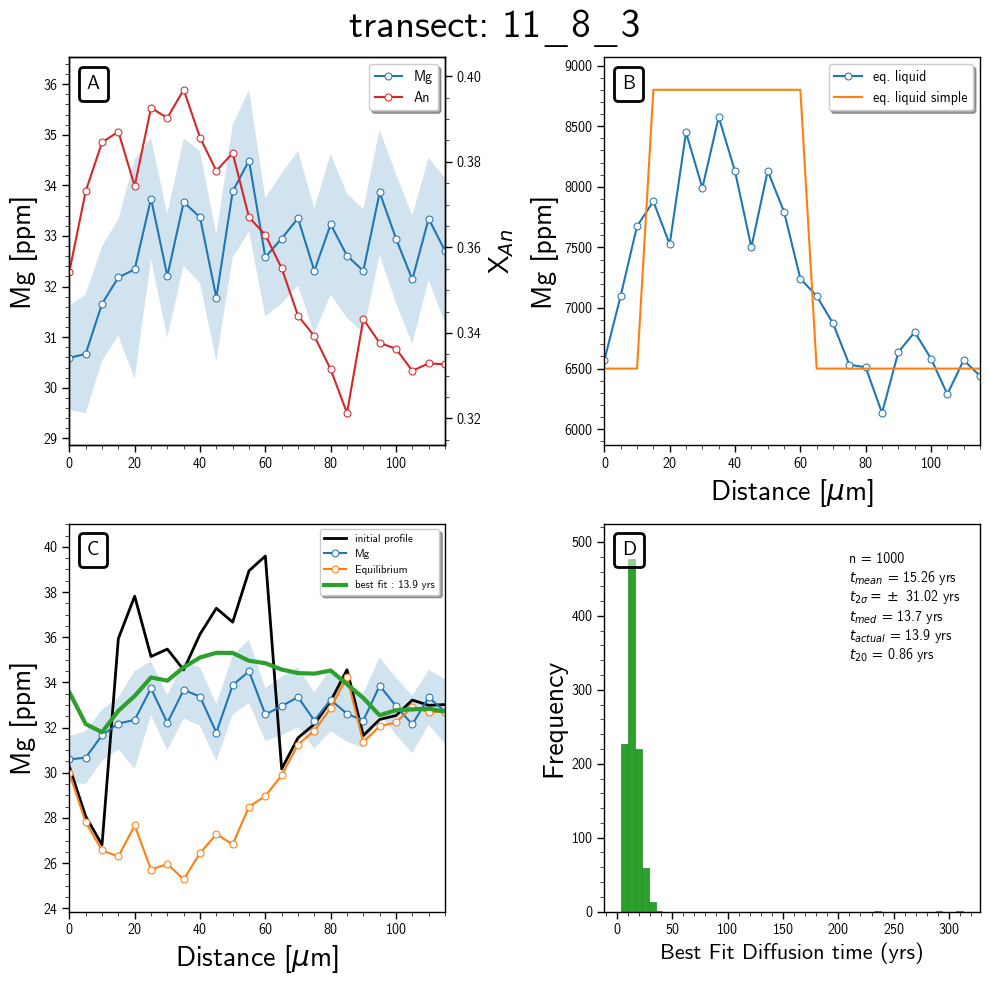

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ms = 5
legend_loc = "upper right"
(l1,) = ax[0, 0].plot(
    dist, te, label=element, c="C0", marker="o", mfc="w", mec="C0", mew=0.75, ms=ms
)
ax[0, 0].fill_between(dist, te + te_unc, te - te_unc, alpha=0.2)
ax3 = ax[0, 0].twinx()
(l2,) = ax3.plot(
    dist, an, label="An", c="C3", marker="o", mfc="w", mec="C3", mew=0.75, ms=ms
)
ax3.set_ylabel(
    "X$_{An}$", fontsize=20,
)
ax[0, 0].set_ylabel("{} [ppm]".format(element), fontsize=20)
ax[0, 0].set_xlim(left=np.min(dist), right=np.max(dist))
ax[0, 0].legend(handles=[l1, l2], loc=legend_loc, fancybox=True, shadow=True)


ax[0, 1].plot(
    dist,
    equilibrium_liquid,
    c=obs_color,
    marker="o",
    mfc="w",
    mec=obs_color,
    ms=ms,
    mew=0.75,
    label="eq. liquid",
)
ax[0, 1].plot(dist, simple_liquid, c=eq_color, label="eq. liquid simple")
ax[0, 1].set_xlabel("Distance [$\mu$m]")
ax[0, 1].legend(loc=legend_loc, shadow=True, fancybox=True)
ax[0, 1].set_xlim(left=np.min(dist), right=np.max(dist))
ax[0, 1].set_ylabel("{} [ppm]".format(element), fontsize=20)


ax[1, 0].plot(dist, initial_profile, "k-", lw=2, label="initial profile")
ax[1, 0].plot(
    dist,
    te,
    label=element,
    c=obs_color,
    marker="o",
    mfc="w",
    mec=obs_color,
    mew=0.75,
    ms=ms,
)
ax[1, 0].fill_between(dist, te + te_unc, te - te_unc, alpha=0.2)
ax[1, 0].plot(
    dist,
    eq_prof,
    c=eq_color,
    marker="o",
    mfc="w",
    mec=eq_color,
    mew=0.75,
    label="Equilibrium",
    ms=ms,
)  # boundary conditions
ax[1, 0].plot(
    dist,
    curves[bf_time],
    "-",
    c=bf_color,
    mec="k",
    lw=3,
    label="best fit : {} yrs".format(np.round(bf_time / makeyears, 2)),
)
ax[1, 0].legend(loc=legend_loc, prop={"size": 8}, ncol=1, fancybox=True, shadow=True)
ax[1, 0].set_ylabel("{} [ppm]".format(element), fontsize=20)
ax[1, 0].set_xlim(left=np.min(dist), right=np.max(dist))
ax[1, 0].set_xlabel("Distance [$\mu$m]", fontsize=20)


mc_results = best_fits / makeyears
# mc_results = mc_results[mc_results > 300]
counts, bins, patches = ax[1, 1].hist(
    mc_results, bins=50, color=bf_color, edgecolor="forestgreen", lw=0.5
)

transform = None

if transform:
    (
        transform_mc_results,
        transform_mean,
        transform_median,
        transform_low,
        transform_high,
    ) = plag.transform_data(mc_results, kind=transform)

    ax[1, 1].text(
        0.55,
        0.9,
        "n = {}".format(mc_results.shape[0]),
        transform=ax[1, 1].transAxes,
        fontsize=10,
    )
    ax[1, 1].text(
        0.55,
        0.85,
        "$t_{{mean}}$ = {} yrs".format(np.round(transform_mean, 2)),
        transform=ax[1, 1].transAxes,
        fontsize=10,
    )
    ax[1, 1].text(
        0.55,
        0.8,
        "$t_{{2\sigma}} = \pm$ {} ; {} yrs".format(
            np.round(transform_mean - transform_low, 2),
            np.round(transform_high - transform_mean, 2),
        ),
        transform=ax[1, 1].transAxes,
        fontsize=10,
    )
    ax[1, 1].text(
        0.55,
        0.75,
        "$t_{{med}}$ = {} yrs".format(np.round(transform_median, 2)),
        transform=ax[1, 1].transAxes,
        fontsize=10,
    )
    ax[1, 1].text(
        0.55,
        0.7,
        "$t_{{actual}}$ = {} yrs".format(np.round(bf_time / makeyears, 2)),
        transform=ax[1, 1].transAxes,
        fontsize=10,
    )
    ax[1, 1].text(
        0.55,
        0.65,
        "$t_{{20}}$ = {} yrs".format(np.round(t20.max(), 2)),
        transform=ax[1, 1].transAxes,
        fontsize=10,
    )


else:

    ax[1, 1].text(
        0.65,
        0.9,
        "n = {}".format(mc_results.shape[0]),
        transform=ax[1, 1].transAxes,
        fontsize=10,
    )
    ax[1, 1].text(
        0.65,
        0.85,
        "$t_{{mean}}$ = {} yrs".format(np.round(mc_results.mean(), 2)),
        transform=ax[1, 1].transAxes,
        fontsize=10,
    )
    ax[1, 1].text(
        0.65,
        0.8,
        "$t_{{2\sigma}} = \pm$ {} yrs".format(np.round(2 * np.std(mc_results), 2)),
        transform=ax[1, 1].transAxes,
        fontsize=10,
    )
    ax[1, 1].text(
        0.65,
        0.75,
        "$t_{{med}}$ = {} yrs".format(np.round(np.median(mc_results), 2)),
        transform=ax[1, 1].transAxes,
        fontsize=10,
    )
    ax[1, 1].text(
        0.65,
        0.7,
        "$t_{{actual}}$ = {} yrs".format(np.round(bf_time / makeyears, 2)),
        transform=ax[1, 1].transAxes,
        fontsize=10,
    )
    ax[1, 1].text(
        0.65,
        0.65,
        "$t_{{20}}$ = {} yrs".format(np.round(t20.max(), 2)),
        transform=ax[1, 1].transAxes,
        fontsize=10,
    )


ax[1, 1].set_xlabel("Best Fit Diffusion time (yrs)", fontsize=16)
ax[1, 1].set_ylabel("Frequency")

fig.suptitle("transect: {}".format(grain), fontsize=28)
fig.tight_layout()


mpl_defaults.label_subplots(ax, location="upper left")

plt.savefig("{}\{}_{}_model_summary.pdf".format(export_path,grain,element),bbox_inches = "tight")

## Save an output report for the model
This will save much of the metadata chosen throughout the model so it can be easily reproduced

In [10]:
if transform:

    output_dict = {
        "grain": grain,
        "element": element,
        "resolution": resolution,
        "step start (idx)": stepstart,
        "step stop (idx)": stepstop,
        "left concentration (ppm)": step_left,
        "middle concentration (ppm)": step_middle,
        "right concentration (ppm)": step_right,
        "best fit (yrs)": bf_time / makeyears,
        "mc mean (yrs)": transform_mean,
        "mc 2sig (yrs)": [transform_low, transform_high],
    }

else:

    output_dict = {
        "grain": grain,
        "element": element,
        "resolution": resolution,
        "step start (idx)": stepstart,
        "step stop (idx)": stepstop,
        "left concentration (ppm)": step_left,
        "middle concentration (ppm)": step_middle,
        "right concentration (ppm)": step_right,
        "best fit (yrs)": bf_time / makeyears,
        "mc mean (yrs)": np.mean(mc_results),
        "mc 2sig (yrs)": np.std(mc_results) * 2,
    }
pd.DataFrame([output_dict]).to_csv("{}\{}_{}_model_summary_test.csv".format(export_path,grain,element),index = False)